# Solving the Ackley Function with Evolutionary Algorithms

The Ackley function is a widely used benchmark for testing optimization algorithms due to its multimodal nature. It is defined as:

$f(x) = -20 \exp\left(-0.2 \sqrt{\frac{1}{n} \sum_{i=1}^n x_i^2}\right) - \exp\left(\frac{1}{n} \sum_{i=1}^n \cos(2\pi x_i)\right) + 20 + e$

Where:
- $x = [x_1, x_2, ..., x_n]$ is the input vector in $\mathbb{R}^n$,
- $n$ is the dimensionality of the problem,
- The domain is typically $x_i \in [-32.768, 32.768]$,
- The global minimum is at $x = [0, 0, ..., 0]$ with $f(x) = 0$.

The function features a nearly flat outer region with a deep central valley, making it challenging for optimization algorithms to converge to the global minimum.

## Visualization

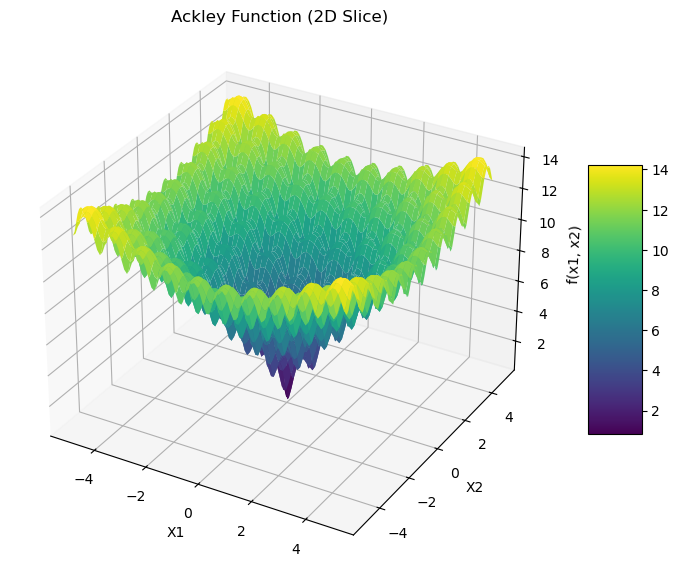

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Ackley function for visualization (2D version)
def ackley_2d(x1, x2):
    a = 20
    b = 0.2
    c = 2 * np.pi
    n = 2  # 2D for visualization
    sum_sq = x1**2 + x2**2
    sum_cos = np.cos(c * x1) + np.cos(c * x2)
    return -a * np.exp(-b * np.sqrt(sum_sq / n)) - np.exp(sum_cos / n) + a + np.e

# Generate data for visualization
x1 = np.linspace(-5, 5, 100)  # Reduced range for clearer visualization
x2 = np.linspace(-5, 5, 100)
X1, X2 = np.meshgrid(x1, x2)
Z = ackley_2d(X1, X2)

# Create 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X1, X2, Z, cmap='viridis', edgecolor='none')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('f(x1, x2)')
ax.set_title('Ackley Function (2D Slice)')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()

## Solving Ackly funciton using pymoo EC algorithms

This notebook demonstrates the use of evolutionary computation (EC) algorithms from the `pymoo` library to minimize the Ackley function. 

The goal is to find the input vector $x$ that yields an objective value as close as possible to 0, comparing the performance of GA, DE, and ES on a 2-dimensional Ackley function over 100 generations.

In [ ]:
import pymoo
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.optimize import minimize
from pymoo.problems import get_problem

# Use pymoo's built-in Ackley function
problem = get_problem("ackley", n_var=2)  # 2-dimensional Ackley function

# Function to run and print results for an algorithm
def run_algorithm(algorithm, problem, name):
    try:
        res = minimize(problem,
                       algorithm,
                       ('n_gen', 100),  # 100 generations
                       seed=1,
                       verbose=False)
        print(f"{name}:")
        print(f"Best solution found: {res.X}")
        print(f"Objective value: {res.F[0]:.6f}\n")
    except Exception as e:
        print(f"Error running {name}: {e}\n")

# 1. Genetic Algorithm (GA)
ga = GA(pop_size=100, elim_duplicate=True)
run_algorithm(ga, problem, "Genetic Algorithm (GA)")

# 2. Differential Evolution (DE)
de = DE(pop_size=100, variant="DE/rand/1/bin", CR=0.7, F=0.5)
run_algorithm(de, problem, "Differential Evolution (DE)")

# Notes on unsupported algorithms in pymoo
print("Notes on other algorithms:")
print("-Evolutionary Strategies (ES): Use DEAP library.")
print("- Genetic Programming (GP): Not natively supported in pymoo. Use DEAP library for tree-based representations.")
print("- Evolutionary Programming (EP): Can be approximated in pymoo with ES by disabling crossover and focusing on mutation.")
print("- Cultural Algorithms (CA): Requires custom implementation with a belief space; not natively supported.")
print("- Co-evolution (CoE): Requires multiple populations; can be approximated with pymoo's multi-objective frameworks.")

NumPy version: 2.1.3
Pymoo version: 0.6.1.3
Genetic Algorithm (GA):
Best solution found: [-0.00292604 -0.00169312]
Objective value: 0.009866

Differential Evolution (DE):
Best solution found: [2.79237013e-09 2.61397036e-09]
Objective value: 0.000000

Notes on other algorithms:
-Evolutionary Strategies (ES): Use DEAP library.
- Genetic Programming (GP): Not natively supported in pymoo. Use DEAP library for tree-based representations.
- Evolutionary Programming (EP): Can be approximated in pymoo with ES by disabling crossover and focusing on mutation.
- Cultural Algorithms (CA): Requires custom implementation with a belief space; not natively supported.
- Co-evolution (CoE): Requires multiple populations; can be approximated with pymoo's multi-objective frameworks.


## Solving Ackly funciton using ES, GP, EP, CA and CoE in DEAP

In [23]:
from deap import base, creator, tools, algorithms
import random

# Ackley function for DEAP
def ackley(individual):
    n = len(individual)
    sum_sq = sum(x**2 for x in individual)
    sum_cos = sum(np.cos(2 * np.pi * x) for x in individual)
    return -20 * np.exp(-0.2 * np.sqrt(sum_sq / n)) - np.exp(sum_cos / n) + 20 + np.e,

# Setup for DEAP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -32.768, 32.768)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", ackley)


# 3. Evolutionary Strategies (ES) with DEAP
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

def run_es():
    pop = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    pop, log = algorithms.eaMuPlusLambda(pop, toolbox, mu=100, lambda_=200, cxpb=0.0, mutpb=1.0, ngen=100, stats=stats, halloffame=hof, verbose=False)
    return hof[0]

best_es = run_es()
print("Evolutionary Strategies (ES) with DEAP:")
print(f"Best solution found: {best_es}")
print(f"Objective value: {ackley(best_es)[0]:.6f}\n")

# 4. Genetic Programming (GP) with DEAP - Simplified as numerical optimization
toolbox.register("expr", tools.initRepeat, list, toolbox.attr_float, n=10)
toolbox.register("individual_gp", tools.initIterate, creator.Individual, toolbox.expr)

def run_gp():
    pop = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=100, stats=stats, halloffame=hof, verbose=False)
    return hof[0]

best_gp = run_gp()
print("Genetic Programming (GP) with DEAP (numerical approximation):")
print(f"Best solution found: {best_gp}")
print(f"Objective value: {ackley(best_gp)[0]:.6f}\n")

# 5. Evolutionary Programming (EP) with DEAP - Mutation only
def run_ep():
    pop = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.0, mutpb=1.0, ngen=100, stats=stats, halloffame=hof, verbose=False)
    return hof[0]

best_ep = run_ep()
print("Evolutionary Programming (EP) with DEAP:")
print(f"Best solution found: {best_ep}")
print(f"Objective value: {ackley(best_ep)[0]:.6f}\n")

# 6. Cultural Algorithms (CA) with DEAP - Fixed
belief_space = []

def update_belief_space(pop):
    global belief_space
    belief_space = sorted(pop, key=lambda x: x.fitness.values[0])[:5]  # Top 5 individuals

def cultural_influence(ind):
    if belief_space and random.random() < 0.3:
        elite = random.choice(belief_space)
        # Ensure we return a list of updated values
        return creator.Individual([x + random.uniform(-0.1, 0.1) * (e - x) for x, e in zip(ind, elite)])
    return ind

toolbox.register("mate_ca", cultural_influence)
toolbox.register("mutate_ca", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)

def run_ca():
    pop = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    for gen in range(100):
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))
        # Apply cultural influence
        offspring = [toolbox.mate_ca(ind) for ind in offspring]
        # Apply mutation
        offspring = [toolbox.mutate_ca(ind)[0] for ind in offspring]
        # Evaluate fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        pop[:] = offspring
        update_belief_space(pop)
        hof.update(pop)
    return hof[0]

best_ca = run_ca()
print("Cultural Algorithms (CA) with DEAP:")
print(f"Best solution found: {best_ca}")
print(f"Objective value: {ackley(best_ca)[0]:.6f}\n")

# 7. Co-evolution (CoE) with DEAP - Simplified competitive co-evolution
def run_coe():
    pop1 = toolbox.population(n=50)
    pop2 = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    for gen in range(100):
        # Evaluate pop1 against pop2
        for ind1, ind2 in zip(pop1, pop2):
            fit1 = ackley(ind1)[0] + random.uniform(-0.1, 0.1) * (ackley(ind2)[0] - ackley(ind1)[0])
            ind1.fitness.values = (fit1,)
        # Evolve pop1
        offspring1 = algorithms.varAnd(pop1, toolbox, cxpb=0.7, mutpb=0.2)
        invalid_ind1 = [ind for ind in offspring1 if not ind.fitness.valid]
        fitnesses1 = toolbox.map(toolbox.evaluate, invalid_ind1)
        for ind, fit in zip(invalid_ind1, fitnesses1):
            ind.fitness.values = fit
        pop1[:] = tools.selTournament(offspring1, len(pop1), tournsize=3)
        hof.update(pop1)
    return hof[0]

best_coe = run_coe()
print("Co-evolution (CoE) with DEAP:")
print(f"Best solution found: {best_coe}")
print(f"Objective value: {ackley(best_coe)[0]:.6f}\n")

Evolutionary Strategies (ES) with DEAP:
Best solution found: [2.9645674098287604, 0.00011271087300868582]
Objective value: 6.882583

Genetic Programming (GP) with DEAP (numerical approximation):
Best solution found: [2.610842064070367e-16, 2.5338159996543872e-17]
Objective value: 0.000000

Evolutionary Programming (EP) with DEAP:
Best solution found: [0.96852472300901, -0.9685114840817526]
Objective value: 3.574452

Cultural Algorithms (CA) with DEAP:
Best solution found: [0.9461278630529885, -0.012063481455388117]
Objective value: 2.584765

Co-evolution (CoE) with DEAP:
Best solution found: [8.641830529142212e-08, 2.280469078485217e-08]
Objective value: 0.000000

